In [23]:
# Basic data analysis for protein proteomics

# First, import things

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import numpy as np
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, normalize
from math import log10, log2, ceil, floor, sqrt
from missingpy import MissForest
import os

from py_scripts import generate_ssgsea_files as gsf
from py_scripts import managing_ssgsea_outputs as mso

from helpers import general_helpers as gh
from helpers import stats_helpers as sh
from helpers import proteomics_helpers as ph
from helpers import mpl_plotting_helpers as mph

In [24]:
# Define the variables in a way that isn't cancer.

# The column names MaxQuant gives blow absolute ass, so rename them
# and only keep what's useful
#
# Note that contaminant filtering happens before we slim down the matrix
rename_cols = {"Gene names" : "Gene name",
               "Peptides" : "Peptides",
               "Sequence coverage [%]" : "Sequence coverage",
               "LFQ intensity 01" : "JE6 R1",
               "LFQ intensity 02" : "JE6 R2",
               "LFQ intensity 03" : "JE6 R3",
               "LFQ intensity 04" : "JE6 R4",
               "LFQ intensity 05" : "JE6 R5",
               "LFQ intensity 06" : "J.TCPTP- R1",
               "LFQ intensity 07" : "J.TCPTP- R2",
               "LFQ intensity 08" : "J.TCPTP- R3",
               "LFQ intensity 09" : "J.TCPTP- R4",
               "LFQ intensity 10" : "J.TCPTP- R5",
               "LFQ intensity 11" : "J.PTPN22- R1",
               "LFQ intensity 12" : "J.PTPN22- R2",
               "LFQ intensity 13" : "J.PTPN22- R3",
               "LFQ intensity 14" : "J.PTPN22- R4",
               "LFQ intensity 15" : "J.PTPN22- R5",
               "LFQ intensity 16" : "J.SHP1- R1",
               "LFQ intensity 17" : "J.SHP1- R2",
               "LFQ intensity 18" : "J.SHP1- R3",
               "LFQ intensity 19" : "J.SHP1- R4",
               "LFQ intensity 20" : "J.SHP1- R5",}

# Headers that will be added down the line
new_heads = ["log2(JE6 R1)", "log2(JE6 R2)", "log2(JE6 R3)", "log2(JE6 R4)", "log2(JE6 R5)", 
            "log2(J.TCPTP- R1)", "log2(J.TCPTP- R2)", "log2(J.TCPTP- R3)", "log2(J.TCPTP- R4)", "log2(J.TCPTP- R5)", 
            "log2(J.PTPN22- R1)", "log2(J.PTPN22- R2)", "log2(J.PTPN22- R3)", "log2(J.PTPN22- R4)", "log2(J.PTPN22- R5)",
            "log2(J.SHP1- R1)", "log2(J.SHP1- R2)", "log2(J.SHP1- R3)", "log2(J.SHP1- R4)", "log2(J.SHP1- R5)",
            "JE6 log2(Mean)", "J.TCPTP- log2(Mean)", "J.PTPN22- log2(Mean)", "J.SHP1- log2(Mean)",
            "JE6 SD", "J.TCPTP- SD", "J.PTPN22- SD", "J.SHP1- SD",
            "JE6 CV%", "J.TCPTP- CV%", "J.PTPN22- CV%", "J.SHP1- CV%",
            "J.TCPTP- vs JE6 log2(Fold Change)", "J.PTPN22- vs JE6 log2(Fold Change)", "J.SHP1- vs JE6 log2(Fold Change)",
            "J.TCPTP- vs JE6 p-value", "J.PTPN22- vs JE6 p-value", "J.SHP1- vs JE6 p-value",
            "J.TCPTP- vs Jurkat q-value", "J.PTPN22- vs Jurkat q-value", "J.SHP1- vs Jurkat q-value",]

# Define the groups for comparisons. I'll do this by index because that's how I like it
# Note to exclude J.TCPTP- R5 and J.PTPN22- R4 because of low abundance, relatively speaking
nor_comp_groups = [[3,4,5,6,7],
                   [8,9,10,11],
                   [13,14,15,17],
                   [18,19,20,21,22]]

log_comp_groups = [[23,24,25,26,27],       # JE6
               [28,29,30,31],    # J.TCPTP-
               [33,34,35,37],  # J.PTPN22-
               [38,39,40,41,42]   # J.SHP1-
              ]
comp_group_labs = ["JE6", "J.TCPTP-", "J.PTPN22-", "J.SHP1-"]

comps = [(1,0), (2,0), (3,0)]

# Colours to use when plotting

colours = [mph.handle_colours("monos", 3),
           mph.handle_colours("pinks", 3),
           mph.handle_colours("blues", 3),
           mph.handle_colours("purples", 3),
           mph.handle_colours("monos", 3),
           mph.handle_colours("pinks", 3),
           mph.handle_colours("blues", 3),
           mph.handle_colours("purples", 3)]

# Plotting strings
comparison_labels = ["J.TCPTP- vs Jurkat", "J.PTPN22- vs Jurkat", "J.SHP1- vs Jurkat"]
yaxis_strs = ["$-\log_{10}(q)$"]

In [25]:
def safe_log2(number):
    try:
        return log2(number)
    except:
        return float("nan")

def safe_log10(number):
    try:
        return log10(number)
    except:
        return float("nan")

def replace_nans_in_qs(qs, ps, og_ps):
    ## Basically iterate through og_ps, add nans and trace back to qs since ps and qs are index matched
    new_qs = []
    inds_seen = []
    position = 0
    for item in og_ps:
        if item != item: ## Nan behaviour
            new_qs.append(item)
        else:                   # Otherwise, find in ps, then in qs
            p_ind = ps.index(item)
            if p_ind not in inds_seen:
                new_qs.append(qs[p_ind])
                inds_seen.append(p_ind)
            else:
                p_ind = ps[position:].index(item)
                new_qs.append(qs[p_ind])
                inds_seen.append(p_ind)
        position+=1
    return new_qs

def uniq_list(a_list):
    seen = []
    for item in a_list:
        if item not in seen:
            seen.append(item)
    return seen

In [26]:
def plot_a_box(ax, centre, width, height, line_kwargs = {"color":"tab:red",
                                                         "linestyle" : "--"}):
    # Plot a width x height box centred at centre
    xs = [centre[0] - 0.5*width, centre[0] + 0.5*width]
    ys = [centre[1] - 0.5*height, centre[1] + 0.5*height]
    
    ax.plot(xs, [ys[0], ys[0]], **line_kwargs)
    ax.plot(xs, [ys[1], ys[1]], **line_kwargs)
    ax.plot([xs[0], xs[0]], ys, **line_kwargs)
    ax.plot([xs[1], xs[1]], ys, **line_kwargs)
    return None

In [27]:
# PCA function to make my life less miserable
def square_bounds(mpl_axes, inplace = False):
    ticks = list(mpl_axes.get_xticks()) + list(mpl_axes.get_yticks())
    if inplace:
        mpl_axes.set_xlim(min(ticks), max(ticks))
        mpl_axes.set_ylim(min(ticks), max(ticks))
    else:
        return min(ticks), max(ticks)

def pca_analysis(a_df, pca_kwargs = dict(n_components = 2,
                                         whiten = False,
                                         svd_solver = "full",
                                         tol = 0)):
    std_scalar = StandardScaler()
    scaled = std_scalar.fit_transform(a_df.transpose())
    pca_analysis = PCA(**pca_kwargs)
    components = pca_analysis.fit_transform(scaled)
    components = gh.transpose(*[list(point) for point in list(components)])
    return components, pca_analysis

def nmf_analysis(a_df, nmf_kwargs = dict(n_components = 2, 
                                     init = "nndsvd", # preserves sparseness
                                     solver = "mu", # multiplicative update
                                     beta_loss = "frobenius", # stable, but slow
                                     alpha_W = 0,  # default
                                     alpha_H = 0,  # default
                                     l1_ratio = 0  # default
                                    )):
    #std_scalar = StandardScaler()
    #scaled = std_scalar.fit_transform(a_df.transpose())
    norms = normalize(a_df)
    nmf_analysis = NMF(**nmf_kwargs)
    W = nmf_analysis.fit_transform(norms)
    H = nmf_analysis.components_
    return H, W
    
def cluster_plotting(dataframes, # list with minimum 1 df
                 groups,     
                 expnames, # should match len(dataframes)
                 filenames,# should match len(dataframes)
                 group_slices, #assumes reps are clustered in list
                 labels,       # should correspons to len(group_slices)
                 colours,      # list of lists, each sublist should correspond to len(group_slices)
                 markers = ["o","^", "s"],
                 cluster = 'PCA', # other option is NNMF
                 markersize=100, 
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                 square = True,
                 pca_kwargs = dict(n_components = 30,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),
                 nmf_kwargs = dict(n_components = 2, 
                                   init = "nndsvd", # preserves sparseness
                                   solver = "mu", # multiplicative update
                                   beta_loss = "frobenius", # stable, but slow
                                   alpha_W = 0,  # default
                                   alpha_H = 0,  # default
                                   l1_ratio = 0  # default
                                    )):
    # Get the data columns from the dataframes, remove
    # missing values, run PCA analysis with sklearn,
    # scatter
    
    # Grab the columns corresponding to the groups of data. Assumes the 'groups' strings
    # are a substring of the column headers
    dfs = [df[[name for name in list(df.columns) if any(s in name for s in groups)]] for df in dataframes]
    # Remove any row with missing values, as PCA doesn't tolerate MVs
    dfs = [df.dropna() for df in dfs]
    axes = []
    i = 0
    print(cluster)
    for df in dfs:
        if cluster.lower() == "pca":
            print('here')
            components,pca = pca_analysis(df, pca_kwargs = pca_kwargs)
        else:
            # will add nmf soon
            print('don')
            components,nmf = nmf_analysis(df, nmf_kwargs = nmf_kwargs)
        fig, ax = plt.subplots(figsize = (6,6))
        # Next, loop over the slices and scatter
        j = 0
        print(len(components[0]))
        for g in group_slices:
            ax.scatter(components[0][g], components[1][g], 
                       color = colours[i][j],
                       marker = markers[j], 
                       s = markersize, 
                       alpha = 0.75,          # my preference
                       label = labels[j],
                       edgecolor = "black",   # my preference
                      )
            j+=1
        ax.set_title(expnames[i], **textdict)
        if cluster.lower() == "pca":
            ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.2f}%)",**textdict)
            ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.2f}%)", **textdict)
            #square_bounds(ax, inplace = True)
        else:
            # will add nmf soon
            ax.set_xlabel(f"Component 1", **textdict)
            ax.set_ylabel(f"Component 2", **textdict)
        if square:
            square_bounds(ax, inplace = True)
        mph.update_ticks(ax, which = "x")
        mph.update_ticks(ax, which ="y")
        ax.legend()
        plt.tight_layout()
        plt.savefig(filenames[i])
        axes.append(ax)
        plt.close()
        i+=1
    return axes



In [28]:
## Multiple Regression, because fuck doing the pairwise bullshit

def format_linreg_strs(coeffs, r2, intercept, label = "Biggest Dong"):
    outstr = f"{label}\n$y={intercept:.3f}"
    for i in range(len(coeffs)):
        outstr += fr"+{coeffs[i]:.3f}x_{{{i+1}}}"
    outstr += f"$\n$R={r2:.3f}$"
    return outstr

def plot_linreg_strs(strs, save = "test.pdf",
                    fontdict = dict(fontfamily = "sans-serif",
                                      font = "Arial",
                                      fontweight = "bold",
                                      fontsize = 2)):
    """
    Just plot the strings to exploit LaTeX math formatting
    """
    fig, ax = plt.subplots()
    # Check how many strings there are, and adjust the axes accordingly
    num = len(strs)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,num)
    ax.set_yticks(list(range(num)))
    # turn off the bounding box
    ax.axis("off")
    # plot the strings
    for i in range(num):
        ax.text(0, i, strs[i], ha = "center", va = "center", **fontdict)
    plt.savefig(save)
    plt.close()
    
def multi_reg_lineplot(file, #dataframe
                       groups = ["t1", "t2", "t3"], #substring of header, group indicator
                       labels = ["0 min", "2 min", "5 min"], # Goes above the strings
                       log2_trans = True,
                       savefile = "test.pdf", # path/to/file.pdf
                       fontdict= dict(fontfamily = "sans-serif",
                                      font = "Arial",
                                      fontweight = "bold",
                                      fontsize = 2)
                       ):
    g_num = len(groups)
    split_f = [file[[c for c in list(file.columns) if groups[i] in c]] for i in range(g_num)]
    if log2_trans:
        split_f = [[list(row) for row in list(g.astype(float).transform(np.log2).to_numpy())] for g in split_f]
    else:
        split_f = [[list(row) for row in list(g.astype(float).to_numpy())] for g in split_f]
    # LinearRegression can't take missing values
    split_f = [[row for row in g if all([item == item for item in row])] for g in split_f]
    xs = [[row[:-1] for row in g] for g in split_f]
    ys = [gh.transpose(*[[row[-1]] for row in g])[0] for g in split_f]
    # Set up the model
    linmods = [LinearRegression() for _ in range(g_num)]
    # and fit it, always assume y is the last replicate in a group
    regs = [linmods[i].fit(xs[i], ys[i]) for i in range(g_num)]
    scores = [sqrt(regs[i].score(xs[i],ys[i])) for i in range(g_num)]
    # Now we make the strings
    strs = [format_linreg_strs(regs[i].coef_, scores[i], regs[i].intercept_, labels[i]) for i in range(g_num)]
    # And pass them to the plotter
    plot_linreg_strs(strs, save=savefile, fontdict = fontdict)
    return None

In [29]:
def hist_matrix(a_matrix, # Assumes no headers, remove them
                 ylabels,
                xlabels,
                bins = 33,
               imputed = None, # Must have the same shape as a_matrix, minus the number of points
               ymax = 150,
                xlims = (15,35),
                ygroup_size = None, # Should be top to bottom
               y_groups = None,     # Should be top to bottom
                title = "Lick mah balls",
                fontdict = dict(fontfamily = "sans-serif",
                                font = "Arial",
                                fontstyle = "normal"),
                primary = ("lavendar", "mediumpurple"),
                secondary = ("pink", "mediumvioletred"),
                figsize = (16,12),
                savefile = "histogram_matrix.pdf",
                missing = [],
               ):
    print(missing)
    font = font_manager.FontProperties(family='sans-serif',
                                   style='normal', size=8)
    fig, ax = plt.subplots(len(ylabels), len(xlabels),
                           figsize = figsize)
    # This is the number of rows in the figure
    for i in range(len(ylabels)):
        # This is the number of cols in the figure,
        # should equal len(xlabels)
        for j in range(len(xlabels)):
            ax[i][j].set_xlim(*xlims)
            ax[i][j].set_ylim(0,ymax)
            if (i,j) not in missing:
                hist_med = sh.median(a_matrix[i][j])
                ax[i][j].hist(a_matrix[i][j], bins = bins,
                              color = primary[0], edgecolor = primary[1],
                              label = fr"$n={len([d for d in a_matrix[i][j] if d == d])}$")
                ax[i][j].plot([hist_med, hist_med], [0,ymax], color = primary[0],
                             linestyle = ":",
                             label = fr"$n_{{MED}}={hist_med:.2f}$")
                if imputed != None:
                    imp_med = sh.median(imputed[i][j])
                    ax[i][j].hist(imputed[i][j], bins = bins,
                                  color = secondary[0], edgecolor = secondary[1],
                                  label = fr"$i={len([d for d in imputed[i][j] if d == d])}$")
                    ax[i][j].plot([imp_med, imp_med], [0,ymax], color = secondary[0],
                                 linestyle = ":",
                                 label = fr"$i_{{MED}}={imp_med:.2f}$")

                # Lifestyle choices 
                ax[i][j].legend(loc = "upper right", prop=font)
            if j != 0:
                ytcks = list(ax[i][j].get_yticks()[1:])
                ax[i][j].set_yticks(ytcks)
                ax[i][j].set_yticklabels(["" for _ in range(len(ytcks))])
            elif (i,j) in missing:
                ytcks = [0] + list(ax[0][0].get_yticks())
                ax[i][j].set_yticks(ytcks)
                mph.update_ticks(ax[i][j],
                                 which = "y",
                                  fontdict = {"fontfamily" : "sans-serif",
                                   "font" : "Arial",
                                   #"ha" : "center",
                                   "fontweight" : "bold",
                                   "fontsize" : "8"})
                ax[i][j].set_ylabel(ylabels[i], fontweight = "bold", fontsize= "8",
                                         **fontdict)
            else:
                mph.update_ticks(ax[i][j],
                                 which = "y",
                                  fontdict = {"fontfamily" : "sans-serif",
                                   "font" : "Arial",
                                   #"ha" : "center",
                                   "fontweight" : "bold",
                                   "fontsize" : "8"})
                ax[i][j].set_ylabel(ylabels[i], fontweight = "bold", fontsize= "8",
                                         **fontdict)
            if i != len(ylabels)-1:
                xtcks = list(ax[i][j].get_xticks()[1:])
                ax[i][j].set_xticks(xtcks)
                ax[i][j].set_xticklabels(["" for _ in range(len(xtcks))])
            elif (i,j) in missing:
                xtcks = [xlims[0]] + list(ax[0][0].get_xticks())
                ax[i][j].set_xticks(xtcks)
                mph.update_ticks(ax[i][j],
                                 which = "x",
                                  fontdict = {"fontfamily" : "sans-serif",
                                   "font" : "Arial",
                                   #"ha" : "center",
                                   "fontweight" : "bold",
                                   "fontsize" : "8"})
                ax[i][j].spines[:].set_visible(False)
            else:
                mph.update_ticks(ax[i][j],
                                     which = "x",
                                      fontdict = {"fontfamily" : "sans-serif",
                                       "font" : "Arial",
                                       #"ha" : "center",
                                       "fontweight" : "bold",
                                       "fontsize" : "8"})
                ax[i][j].set_xlabel(xlabels[j], fontweight = "bold", fontsize = 8,
                                        **fontdict)
    # Get the spacing correct
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    if y_groups != None and ygroup_size != None:
        # Place the text strings where they should go
        # These are in figure units, not axes units
        fig.text(0.02,0.45, title, rotation = 90,
                fontweight = "bold", fontsize = "14",
                 **fontdict)
        # Loop over the group sizes in reverse order
        displacement = 0
        index = 0
        for gsize in [ygroup_size[-i] for i in range(len(ygroup_size))]:
            # Calculate displacement for group
            center = (gsize/sum(ygroup_size))/2 + displacement
            fig.text(0.05, center, y_groups[index], rotation = 90,
                     va = "center", ha = "center",
                     fontweight = "bold", fontsize = "14",
                     **fontdict)
            displacement += gsize/sum(ygroup_size)
            index += 1
    plt.savefig(savefile)
    plt.close()
    return None



In [30]:
def write_gct_file(index,    # Flanking sequences with -p 
                    values,   # values per flanking sequence, len(values[i]) == len(headers), len(values) == len(index)
                    headers, # Headers for the columns
                    outfile = "bullshit.gct" # File to write, include path and .gct
                    ):
    # GCT file has some info up top, we take it
    gct = [[fr"#1.3"], # Tells programs its a GCT 1.3 file
           [len(index), len(headers), 0, 0], # number of rows, number of cols, and metadata shit
           ["flanking_seq"] + headers] 
    for i in range(len(index)):
        gct.append([index[i]] + values[i])
    gct = [gh.list_to_str(row) for row in gct]
    gh.write_outfile(gct, outfile, writestyle = "w")
    return None

def ptmsea_transform(a_qvalue, a_foldchange, head = "No"):
    if type(a_qvalue) == str or type(a_foldchange) == str:
        return head
    if a_qvalue != a_qvalue or a_foldchange != a_foldchange:
        return float("nan")
    if a_foldchange < 0:
        return -10 * safe_log10(a_qvalue) *-1
    else:
        return -10 * safe_log10(a_qvalue) * 1

In [38]:
##############################################################################################################
#
#         Read the data and to basic filtering
# Read the file
proteins = gh.read_file("proteinGroups.txt")
print(f"Total protein groups: {len(proteins)-1}")

proteins = gh.filter_matrix(proteins, 
                            "Potential contaminant", 
                            "+", 
                            False)
print(f"\tWithout contaminants: {len(proteins)-1}")
proteins = gh.filter_matrix(proteins, 
                            "Reverse", 
                            "+", 
                            False)
print(f"\tWithout decoys: {len(proteins)-1}")
proteins = gh.filter_matrix(proteins, 
                            "Sequence coverage [%]", 
                            "10", 
                            False,
                            compare = "<=")
print(f"\tSequence Coverage > 10%: {len(proteins)-1}")

# Now that we've cleaned up, filter the matrix
proteins = gh.select_cols(proteins, rename_cols)

# Make number great again
proteins = [gh.transform_values(row, transform = float) for row in proteins]
proteins = [gh.replace_value(row, 0, float("nan")) for row in proteins]

data_ends = [proteins[0].index("JE6 R1"), proteins[0].index("J.SHP1- R5")]
proteins = [row for row in proteins if not all([item != item for item in row[data_ends[0]:data_ends[1]]])]
print(f"\t\tRemoving any row with all missing values for the data, because MaxQuant sucks.")
print(f"\t\t{len(proteins) - 1} rows remaining.")

proteins_df = pd.DataFrame(proteins[1:], columns = proteins[0])

#
#
##############################################################################################################
#
#      Imputation Zone, Random Forest

# imputed.csv is all data imputation, 
# imputed2.csv is without badreps
tmp_file = "tmp/imputed.csv"

colnames = [c for c in list(rename_cols.values()) if " R" in c]

remove_badreps = False

if remove_badreps:
    colnames = [c for c in colnames if c not in ["J.PTPN22- R4", "J.TCPTP- R5"]]

# Impute missing values just because
if os.path.exists(tmp_file):
    imputed_df = pd.read_csv(tmp_file)
    hist_data = [list(np.log2(proteins_df[c]).to_numpy()) for c in colnames]
    imputed = [list(np.log2(imputed_df[c]).to_numpy()) for c in colnames]
    for col in colnames:
        proteins_df[col] = np.log2(imputed_df[col])
else:
    imputer = MissForest(random_state = 69)
    #print(proteins_df[colnames])
    imputed_data = imputer.fit_transform(proteins_df[colnames].to_numpy().transpose())
    imputed_df = pd.DataFrame(imputed_data.transpose(), columns = colnames)
    imputed_df.to_csv(tmp_file)
    hist_data = [list(np.log2(proteins_df[c]).to_numpy()) for c in colnames]
    imputed = [list(np.log2(imputed_df[c]).to_numpy()) for c in colnames]
    for col in colnames:
        proteins_df[col] = np.log2(imputed_df[col])

if remove_badreps:
    group_slices = [slice(0,5), slice(5,9), slice(9,13), slice(13,18)]
else:
    group_slices = [slice(0,5), slice(5,10), slice(10,15), slice(15,20)]

imputed = [[imputed[i][j] for j in range(len(imputed[i])) if hist_data[i][j] != hist_data[i][j]] for i in range(len(imputed))]
hist_data = [[item for item in col if item == item] for col in hist_data]

imputed = [imputed[s] for s in group_slices]
new_hist_data = [hist_data[s] for s in group_slices]

#
#
##############################################################################################################
#
#      Finish the statistics

## Basic Data Stuff, but put everything back into the main proteins lists because
## I fucking hate dataframes

heads = proteins[0] + new_heads
proteins = proteins[1:]

proteins_log = [[float(item) for item in row] 
                for row in list(proteins_df[colnames].to_numpy())]


# Do basic statistics/math stuff using the comparisons we want to make

### log2 trasform data
proteins = [proteins[i] + proteins_log[i] for i in range(len(proteins))]
proteins = [row + [safe_log2(sh.mean([row[i] for i in group],
                                     threshold = 3)) for group in nor_comp_groups] for row in proteins]
### Standard Deviation
proteins = [row + [sh.standard_deviation([row[i] for i in group],
                                         threshold = 3) for group in log_comp_groups] for row in proteins]
### CV%
proteins = [row + [sh.standard_deviation([row[i] for i in group],
                                         threshold = 3) / sh.mean([row[i] for i in group],
                                                                   threshold = 3)*100 for group in log_comp_groups] 
            for row in proteins]
### Log2 fold change, just use the means calculated. JE6 mean should be -12 at this point
proteins = [row + [row[-11]-row[-12],
                   row[-10]-row[-12],
                   row[-9]- row[-12]] for row in proteins]
### TTests
proteins = [row + [sh.TTest([comp_group_labs[c[0]], [row[i] for i in log_comp_groups[c[0]]]],
                            [comp_group_labs[c[1]], [row[i] for i in log_comp_groups[c[1]]]],
                            test_type = "w",
                            threshold = 3).output[0]["pvalue"][0] for c in comps]
           for row in proteins]
### Global FDR requires a lil work
ps = gh.unpack_list(gh.transpose(*[row[-3:] for row in proteins]))
clean_ps = [item for item in ps if item == item]
qs = list(sh.storey(clean_ps, pi0=1)["qvalue"].astype(float).to_numpy())
qs = replace_nans_in_qs(qs, clean_ps, ps)
qs = [qs[i*len(proteins):(i+1)*len(proteins)] for i in range(3)]
qs = gh.transpose(*qs)
proteins = [proteins[i] + qs[i] for i in range(len(proteins))]

# MAke a dataframe using only the significant things
proteins_sig = [row for row in proteins if any([item < 0.05 for item in row[-3:]])]
proteins_sig = pd.DataFrame(sorted(proteins_sig, key=lambda x: x[0]), columns = heads)
proteins_sig.to_excel("sig_output.xlsx")
proteins_df = pd.DataFrame(proteins, columns = heads)
proteins_df.to_excel("proteins.xlsx")


Total protein groups: 4904
	Without contaminants: 4877
	Without decoys: 4825
	Sequence Coverage > 10%: 4663
		Removing any row with all missing values for the data, because MaxQuant sucks.
		3679 rows remaining.


/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:844: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  type(pd.Series()),
/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:850: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  type(pd.Series()),
/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:853: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if type(pvals) == type(pd.Series()) or type(pvals) == type(pd.DataFrame()):
/home/redas/py3/lib/python3.10/site-packages/helpers/stats_helpers.py:867: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a futu

Value for pi0: 1


In [39]:
##############################################################################################################
#
#     Making a histogram to look at the effect of imputation
#     (and the two bad replicates)

hist_savefiles = ["figs/postimp/log2_replicate_distr_protein.pdf"]


if remove_badreps:
    missing = [[], [4], [3], []]
    # Replace the missing replicates with
    hist_data = []
    for i in range(len(hist_data)):
        hist_data.append([])
        for j in range(5):
            if j in missing[i]:
                hist_data[i].append([])
            else:
                hist_data[i].append(new_hist_data[i][j])
else:
    missing = [[], [ ], [ ], []]
    hist_data = new_hist_data

# Should be 4 rows, 
hist_matrix(hist_data, # Assumes no headers, remove them
            ["Jurkat (E6.1)", "J.TCPTP- (T2 1C10)", "J.PTPN22- (P1 1C1)", "J.SHP1- (S1 2C4)"],
            ["R1" , "R2", "R3", "R4", "R5"],
            bins = 33,
            imputed = imputed, # Must have the same shape as a_matrix, minus the number of points
            ymax = 500,
            xlims = (10,40),
            ygroup_size = [2,2], # Should be top to bottom
            y_groups = ["0.04% DMSO", fr"20 $\mu$M U0126"],     # Should be top to bottom
            title = "Phosphatase KO Protein Profiling Imputation",
            fontdict = dict(fontfamily = "sans-serif",
                                font = "Arial",
                                fontstyle = "normal"),
            primary = ("lavender", "mediumpurple"),
            secondary = ("pink", "mediumvioletred"),
            figsize = (16,12),
            savefile = hist_savefiles[0],
            missing = missing)
#
#
##############################################################################################################

[[], [], [], []]


In [40]:
##############################################################################################################
#
#         PCA Plotting using the imputed data

log_abund_inds = [min(gh.unpack_list(log_comp_groups)), max(gh.unpack_list(log_comp_groups))]
log_abund = [row[log_abund_inds[0]:log_abund_inds[1]+1] for row in proteins] # grab log abundances

pca_outfile = "figs/postimp/ko_protein_pca.pdf"


multi_reg_lineplot(pd.DataFrame(log_abund, columns = new_heads[:20]), groups = comp_group_labs,
                   labels = comp_group_labs, log2_trans = False,
                   savefile = "figs/postimp/multi_linreg.pdf")

pca_ax = cluster_plotting([pd.DataFrame(log_abund, columns = new_heads[:20])], # list with minimum 1 df
                 comp_group_labs,         
                 [fr"PCA Clustering, Phosphatase KOs"],
                 [pca_outfile],
                 [slice(5*i,5*(i+1)) for i in range(4)],
                 ["JE6", "J.TCPTP-", "J.PTPN22-","J.SHP1-"],
                 [[c[1] for c in colours[:4]]],
                 markers = ["o", "^", "s", "d"],
                 cluster = 'PCA',
                 markersize=100,
                 textdict = dict(fontfamily = "sans-serif",
                 font = "Arial",
                 fontweight = "bold",
                 fontsize = 10),
                          square = False,
                 pca_kwargs = dict(n_components = 5,
                                   whiten = False,
                                   svd_solver = "full",
                                   tol = 0),)





PCA
here
20


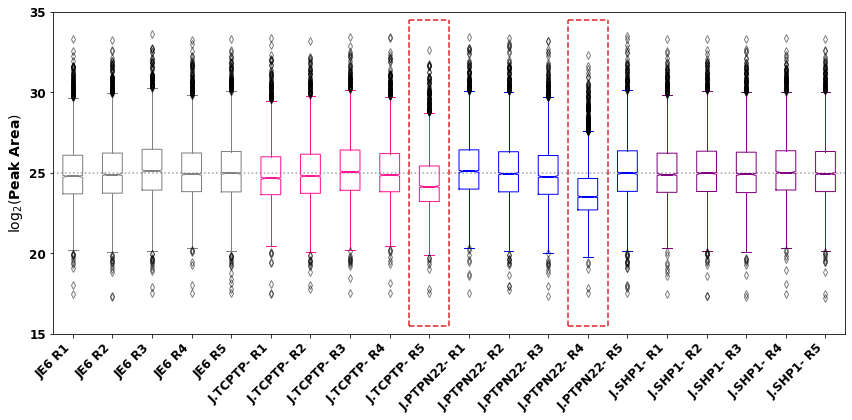

In [41]:
##############################################################################################################
#
#         Intensity distributions on the imputed data

# Find the bad replicates for TCPTP and PTPN22
fig, ax = plt.subplots(figsize = (12,6))
bp_colours = [colours[i][1] for i in range(4)]

ticks = ["JE6 R1", "JE6 R2", "JE6 R3", "JE6 R4", "JE6 R5",
         "J.TCPTP- R1", "J.TCPTP- R2", "J.TCPTP- R3" ,"J.TCPTP- R4", "J.TCPTP- R5",
         "J.PTPN22- R1", "J.PTPN22- R2", "J.PTPN22- R3","J.PTPN22- R4","J.PTPN22- R5",
         "J.SHP1- R1", "J.SHP1- R2", "J.SHP1- R3", "J.SHP1- R4", "J.SHP1- R5"]

bp_data = gh.transpose(*log_abund)
bp_data = [[item for item in col if item == item] for col in bp_data]

ax.plot([0.5,20.5], [25,25], color = "grey", linestyle = ":", alpha = 0.75)

bp = ax.boxplot(bp_data, notch = True)

ax.set_xticks(list(range(1,21)))
ax.set_xticklabels(ticks, rotation = 45,  ha = "right", va = "top", fontfamily = "sans-serif", 
                   font = "Arial", fontweight = "bold", fontsize = 12)
ax.set_ylabel(fr"$\log_{{2}}($Peak Area$)$", fontfamily = "sans-serif", 
                   font = "Arial", fontweight = "bold", fontsize = 14)

for i in range(20):
    c = color = bp_colours[i//5]
    bp["fliers"][i].set(alpha = 0.5, color = c, marker = "d", markersize = 5)
    bp["medians"][i].set(color = c, linewidth = 2)
    bp["boxes"][i].set(color=c)

for j in range(40):
    c = color = bp_colours[j//10]
    bp["whiskers"][j].set(color = c)
    bp["caps"][j].set(color = c)
    
plot_a_box(ax, (10,25), 1,19)
plot_a_box(ax, (14,25), 1,19)

mph.update_ticks(ax, which="y")

ax.set_ylim(15,35)
plt.tight_layout()
plt.savefig("figs/postimp/intensity_distr.pdf")

#
#
##############################################################################################################

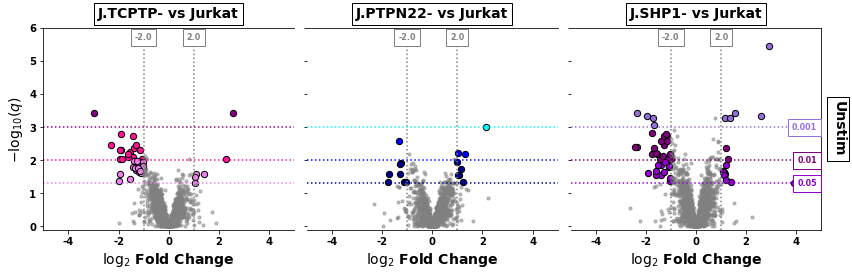

In [42]:
##############################################################################################################
#
#         Volcano plots (wooooot) with bad reps tossed

fc_inds = [item for item in heads if "Fold" in item]
fc_inds = [heads.index(item) for item in fc_inds]

q_inds = [item for item in heads if "q-value" in item]
q_inds = [heads.index(item) for item in q_inds]

fcs = gh.transpose(*[[row[i] for i in fc_inds] for row in proteins])
qs = gh.transpose(*[[row[i] for i in q_inds] for row in proteins])

max([item for item in gh.unpack_list(fcs) if item == item])

mph.volcano_array([qs], [fcs],
                  sig_cutoffs = [0.001, 0.01, 0.05],
                  colours = [[colours[1][:3], colours[2][:3], colours[3][:3]],
                             [colours[1][:3], colours[2][:3], colours[3][:3]]],
                  top_labels = ["J.TCPTP- vs Jurkat", "J.PTPN22- vs Jurkat", "J.SHP1- vs Jurkat"],
                  right_labels = ["Unstim"],
                  left_labels = [fr"$-\log_{{10}}(q)$", fr"$-\log_{{10}}(q)$"],
                  bottom_labels = [fr"$\log_{{2}}$ Fold Change" for _ in range(3)],
                  fc_cutoff = 1 ,
                  save_arr = "figs/volcano.pdf",
                  xlim = 5,
                  ylim = 6)

#
#
##############################################################################################################

In [43]:
##############################################################################################################
#
#         Generate the "peptide" plots

import os

def make_all_pepplots(peptide_list, path = "outputs/graphics",
                      subset = ["all"], exclude = [], comparisons = [],
                      foldchange_group = None,
                      global_max = 6):
    """
    """
    if global_max == None:
        max_val = math.ceil(max([max(p.vals) for p in peptide_list]))
        min_val = math.floor(min([min(p.vals) for p in peptide_list]))
        hm_max = math.ceil(max([max(p.means) for p in peptide_list]))
        hm_min = math.floor(min([min(p.means) for p in peptide_list]))
        hm = [-max([abs(hm_min), abs(hm_max)]), max([abs(hm_min), abs(hm_max)])]
        fc_max = math.ceil(max([max(p.fc) for p in peptide_list]))
        fc_min = math.floor(min([min(p.fc) for p in peptide_list]))
        fc = [-max([abs(fc_min), abs(fc_max)]), max([abs(fc_min), abs(fc_max)])]
    else:
        fc = [-global_max, global_max]
    for p in peptide_list:
        if not os.path.exists(f"{path}/{p.gene.lower()}/heatmaps"):
            os.makedirs(f"{path}/{p.gene.lower()}/heatmaps")
        p.heatmap(d_type = "foldchange",
                  path = f"{path}/{p.gene.lower()}/heatmaps/", 
                  maxs = fc,
                  subset = subset, exclude = exclude)
        plt.close()

pcomp = [ph.Peptide(list(proteins_df.iloc[i][[col for col in list(proteins_df.columns) if " R" in col]].astype(float)),
                    [col for col in list(proteins_df.columns) if " R" in col],
                    comp_group_labs,
                    "NA",
                    statistics = list(proteins_df.iloc[i][[col for col in list(proteins_df.columns) if "q-value" in col]].astype(float)),
                    statistics_headers =[col for col in list(proteins_df.columns) if "q-value" in col],
                    foldchange = list(proteins_df.iloc[i][[col for col in list(proteins_df.columns) if "Fold Change" in col]].astype(float)),
                    foldchange_headers = comparison_labels,
                    sites = "",
                    gene = proteins_df.iloc[i]["Gene name"],
                    unique_id = proteins_df.iloc[i]["Gene name"],
                    colours = colours[0][:4] + colours[1][:4] + colours[2][:4] + colours[3][:4],
                    markers = ["o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",
                               "o", "o", "s", "s",]) for i in range(len(proteins_df))]

make_all_pepplots(pcomp,
                  path = "figs/protein_plots",
                  foldchange_group = "JE6")

#
#
##############################################################################################################

In [44]:
##############################################################################################################
#
#

# Make GCT file for GSEA, because why not
### First, create a new matrix with the G-SEA transformation

gname = [row[heads.index("Gene name")] for row in proteins]
fcs_qs_cols = [heads.index(item) for item in heads if "Fold Change" in item or "q-value" in item]
fcs_qs = [[row[ind] for ind in fcs_qs_cols] for row in proteins]
vals = [[ptmsea_transform(row[i+3], row[i]) for i in range(3)] for row in fcs_qs]

write_gct_file(gname, vals, ["J.TCPTP-", "J.PTPN22-", "J.SHP1-"], "figs/gsea_data/run_data/data.gct")

#gsf.imp_main("./figs/gsea_data/run_data", "data", "./r_scripts/ssGSEA2.0.R",
             "databases/gene_sets.gmt")


# This is going to fail because our cell lines have periods in them and
# R uses periods as delimiters for some dumb fucking reason
#mso.imp_main("./figs/gsea_data", "output-combined.gct")

#
#
##############################################################################################################

IndentationError: unexpected indent (23537123.py, line 16)